# NBA Rookie Success Model
Introduction to Data Science 2018 <br>
By: Travis Tiner and Jake Kerr <br>

## Introduction and Motivation
We enjoy sports, specifically the NBA. We have heard about teams putting players into models to predict their potential, and thought it would be interesting to create something similar to that. <br>
<br>
To accomplish this, we scraped the website basketball-reference.com, and pulled rookie year and career statistics from players' pages.


In [77]:
# imports and setup 
from bs4 import BeautifulSoup
# you can use either of these libraries to get html from a website
import requests
import urllib.request
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import re
from math import isnan

import pandas as pd
import scipy as sc
import numpy as np
import time
import statsmodels.formula.api as sm
from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import math as mt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans, AgglomerativeClustering

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10, 6) 
from string import ascii_lowercase

## Getting all players' links ##

In [2]:
#Get all the pages for each letter
url = "https://www.basketball-reference.com/players"
all_letters = ""
html = {}
i = 0
for x in ascii_lowercase:
    if x == 'x':
        pass
    else:
        link = url + '/' + str(x) + '/'
        with urllib.request.urlopen(link) as response:
            html[i] = response.read()
            html[i] = html[i].decode('utf-8')
        all_letters = all_letters + str(html[i])
        i += 1

In [3]:
with open('all_letters.html','w') as new_file:
    new_file.write(all_letters)

In [4]:
letters_soup = BeautifulSoup(open('all_letters.html',encoding = 'utf-8'), "html.parser")

In [5]:
#Get every players' link
links = []
url = "https://www.basketball-reference.com"
for x in letters_soup.find_all(class_="left "):
    if x.get("data-stat") == "player":
        link_tail = x.find("a").get("href")
        link = url + str(link_tail)
        links.append(link)


## Initialize dataframes that we will be storing information in ##

In [ ]:
rookie = []
columns_pergame_r = ['Name','link','Year','Age','Team','League','Position','Games Played','Games Started','MinPerGame','FGPerGame','FGAPerGame','FG%PerGame','3pPerGame','3PAPerGame','3p%PerGame','2pPerGame','2pAPerGame','2p%PerGame','eFG%PerGame','FTPerGame','FTAPerGame','FT%PerGame','ORGPerGame','DRBPerGame','TotalRebPerGame','AstPerGame','StealPerGame','BlkPerGame','TOVPerGame','FoulsPerGame','PtsPerGame']
rookie_pergame = pd.DataFrame(columns = columns_pergame_r)
columns_per100_r = ['Name','link','Year','Age','Team','League','Position','Games Played','Games Started','TotalMin','FGPer100Poss','FGAPer100Poss','FG%Per100Poss','3pPer100Poss','3PAPer100Poss','3p%Per100Poss','2pPer100Poss','2pAPer100Poss','2p%Per100Poss','FTPer100Poss','FTAPer100Poss','FT%Per100Poss','ORGPer100Poss','DRBPer100Poss','TotalRebPer100Poss','AstPer100Poss','StealPer100Poss','BlkPer100Poss','TOVPer100Poss','FoulsPer100Poss','PtsPer100Poss','blank','ORtg','DRtg']
rookie_per100 = pd.DataFrame(columns = columns_per100_r)
columns_advanced_r = ['Name','link','Year','Age','Team','League','Position','Games Played','TotalMin','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','blank','OWS','DWS','WS','WS/48','blank','OBPM','DBPM','BPM','VORP']
rookie_advanced = pd.DataFrame(columns = columns_advanced_r)

career = []
columns_pergame_c = ['Name','link','Year','blank','blank','League','blank','Games Played','Games Started','MinPerGame','FGPerGame','FGAPerGame','FG%PerGame','3pPerGame','3PAPerGame','3p%PerGame','2pPerGame','2pAPerGame','2p%PerGame','eFG%PerGame','FTPerGame','FTAPerGame','FT%PerGame','ORGPerGame','DRBPerGame','TotalRebPerGame','AstPerGame','StealPerGame','BlkPerGame','TOVPerGame','FoulsPerGame','PtsPerGame']
career_pergame = pd.DataFrame(columns = columns_pergame_c)
columns_per100_c = ['Name','link','Year','blank','blank','League','blank','Games Played','Games Started','TotalMin','FGPer100Poss','FGAPer100Poss','FG%Per100Poss','3pPer100Poss','3PAPer100Poss','3p%Per100Poss','2pPer100Poss','2pAPer100Poss','2p%Per100Poss','FTPer100Poss','FTAPer100Poss','FT%Per100Poss','ORGPer100Poss','DRBPer100Poss','TotalRebPer100Poss','AstPer100Poss','StealPer100Poss','BlkPer100Poss','TOVPer100Poss','FoulsPer100Poss','PtsPer100Poss','blank','ORtg','DRtg']
career_per100 = pd.DataFrame(columns = columns_per100_c)
columns_advanced_c = ['Name','link','Year','blank','blank','League','blank','Games Played','TotalMin','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','blank','OWS','DWS','WS','WS/48','blank','OBPM','DBPM','BPM','VORP']
career_advanced = pd.DataFrame(columns = columns_advanced_c)

def get_num(x):
    return int(''.join(ele for ele in x if ele.isdigit()))

awards = []
columns_a = ['Name','link','MVPs','All-Star Games','All-NBA Teams','All-Rookie Team','ROY']
career_awards = pd.DataFrame(columns = columns_a)
zeros = [0,0,0,0,0,0,0]

columns_dp = ['Name','link','Draft_Pick']
draft_pick = pd.DataFrame(columns = columns_dp)
zeros1 = [0,0,0]


## This cell will scrape and grab everything we need ##

In [2]:
# Get everything

j=1
chrome_options = Options()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(chrome_options=chrome_options)
start_time = time.time()
for i in range(3646, len(links)):
    j+=1
    iter_time = time.time()
    url = links[i]
    driver.get(url)
    players_soup = BeautifulSoup(driver.page_source,'html.parser')
    for x in players_soup.find_all(id="per_game"):
        for q in players_soup.find("h1"):
            rookie.append(q)
            career.append(q)
        rookie.append(url[47:-5])
        career.append(url[47:-5])
        for y in x.find_all("tr")[1]:
            rookie.append(y.get_text())
        if len(rookie) == 32:
            rookie_pergame.loc[i] = rookie  ##Get rookie_pergame
        rookie = []
        for r in x.find_all("tfoot"):
            for s in r.find_all("tr")[0]:
                career.append(s.get_text())
        if len(career) == 32:
            career_pergame.loc[i] = career #Get career_pergame
        career = []
        
    for x in players_soup.find_all(id="per_poss"):
        for q in players_soup.find("h1"):
            rookie.append(q)
            career.append(q)
        rookie.append(url[47:-5])
        career.append(url[47:-5])
        for y in x.find_all("tr")[1]:
            rookie.append(y.get_text())
        if len(rookie) == 34:
            rookie_per100.loc[i] = rookie #Get rookie_per100
        rookie = []  
        
        for z in x.find_all("tfoot"):
            for y in z.find_all("tr")[0]:
                career.append(y.get_text())
        if len(career) == 34:
            career_per100.loc[i] = career #Get career_per100
        career = []
        
    for x in players_soup.find_all(id="advanced"):
        for q in players_soup.find("h1"):
            rookie.append(q)
            career.append(q)
        rookie.append(url[47:-5])
        career.append(url[47:-5])
        for y in x.find_all("tr")[1]:
            rookie.append(y.get_text())
        if len(rookie) == 31:
            rookie_advanced.loc[i] = rookie #Get rookie_advanced
        rookie = []
        
        for z in x.find_all("tfoot"):
            for y in z.find_all("tr")[0]:
                career.append(y.get_text())
        if len(career) == 31:
            career_advanced.loc[i] = career #Get career_advanced
        career = []
        
    for x in players_soup.find_all(id="info"): #Get awards
        if x.find_all(id="bling") != []:
            career_awards.loc[i] = zeros
            career_awards['link'].loc[i] = url[47:-5]
            for y in x.find_all("li"):
                for q in players_soup.find("h1"):
                    career_awards['Name'].loc[i] = q
                career_awards['link'].loc[i] = url[47:-5]
                result = y.get_text()
                if "x MVP" in result:
                    career_awards['MVPs'].loc[i] = get_num(result)
                if re.findall(r'\d\sMVP',result) != []:
                    career_awards['MVPs'].loc[i] = 1
                if "All Star" in result:
                    career_awards['All-Star Games'].loc[i] = get_num(result)
                if "All-NBA" in result:
                    if get_num(result) > 30: #For when it says 2018 All-NBA, this means they only won once. We don't want it saying they won 2018 times
                        career_awards['All-NBA Teams'].loc[i] = 1
                    else:
                        career_awards['All-NBA Teams'].loc[i] = get_num(result)
                if "All-Rookie" in result:
                    career_awards['All-Rookie Team'].loc[i] = 1
                if "ROY" in result:
                    career_awards['ROY'].loc[i] = 1
                result = ""
        else:
            career_awards.loc[i] = zeros
            career_awards['link'].loc[i] = url[47:-5]
            for q in players_soup.find("h1"):
                career_awards['Name'].loc[i] = q
            
    for x in players_soup.find_all(id="meta"): #Get their draft position
        draft_pick.loc[i] = zeros1
        result = x.get_text()
        for q in players_soup.find("h1"):
            draft_pick['Name'].loc[i] = q
        draft_pick['link'].loc[i] = url[47:-5]
        if re.findall(r'\d{1,3}\w\w\soverall',result) != []:
            pick = re.findall(r'\d{1,3}\w\w\soverall',result)[0]
            draft_pick['Draft_Pick'].loc[i] = re.findall(r'\d{1,3}',pick)[0]
        else: 
            draft_pick['Draft_Pick'].loc[i] = np.nan
driver.close()

### Here is an example of a page we are trying to scrape from ###
![LBJ Page.png](LBJ Page.png)

<br> So there are three different tables that we are pulling from, and from each of these tables we are grabbing the career stats and the rookie stats, as well as an awards table. We need to combine all of these into one big rookie table and one big career table.

In [5]:
career_pergame = pd.read_csv('career_pergame.csv',index_col=0)

In [6]:
career_advanced = pd.read_csv('career_advanced.csv',index_col=0)

In [7]:
career_per100 = pd.read_csv('career_per100.csv',index_col=0)

In [8]:
#rookie datasets
rookie_pergame = pd.read_csv('per_game.csv', index_col = 0)

In [9]:
rookie_advanced = pd.read_csv('rookie_advanced.csv', index_col = 0)

In [10]:
rookie_per100 = pd.read_csv('per_100.csv', index_col = 0)

In [11]:
awards = pd.read_csv('career_awards.csv',index_col=0)

In [12]:
draft_pick = pd.read_csv('draft_pick.csv',index_col=0)

# Delete this cell and cells above #

In [13]:
rookie_awards = awards[['Name','link','ROY','All-Rookie Team']]

In [14]:
career_awards = awards[['Name','link','MVPs','All-Star Games','All-NBA Teams']]

In [15]:
rookie3 = rookie_pergame.merge(rookie_per100,on=['Name','link','Year','Age','Position','Games Played','Games Started'])
rookie2 = rookie3.merge(rookie_advanced, on=['Name','link','Year','Age','Position','Games Played'])
rookie1 = rookie2.merge(rookie_awards, on=['Name','link'])
rookie = rookie1.merge(draft_pick,on=['Name','link'])

In [16]:
young_players = rookie[rookie['Year'].isin(['2017-18','2016-17','2015-16','2014-15'])]
young_players = young_players[['Name','link']]

In [17]:
cols = [c for c in rookie.columns if c.lower()[:5] != 'blank']
rookie = rookie[cols]

In [18]:
rookie = rookie.drop(['Team_x','League_x','Team_y','League_y','TotalMin_x','TotalMin_y','Games Started','Team','League'],axis=1)

In [19]:
rookie = rookie.merge(young_players, on=['Name','link'], how='outer', indicator=True).query("_merge != 'both'").drop('_merge', axis=1).reset_index(drop=True)

In [20]:
persons_of_interest = rookie[['Name','link']]

In [21]:
career3 = career_pergame.merge(persons_of_interest, on=['Name','link'])
career2 = career3.merge(career_per100, on=['Name','link','Games Played'])
career1 = career2.merge(career_advanced, on=['Name','link','Games Played'])
career = career1.merge(career_awards, on=['Name','link'])

In [22]:
cols = [c for c in career.columns if c.lower()[:5] != 'blank']
career = career[cols]
career = career.drop(['Year_x','League_x','Games Started_x','Year_y','League_y','Games Started_y','TotalMin_x','TotalMin_y'],axis=1)

In [85]:
#r for rookie c for career
players = rookie.merge(career, left_index=True, right_index=True, suffixes=["_r", "_c"])


0.629563719612
Intercept       4.977844e-80
PtsPerGame_r    0.000000e+00
dtype: float64


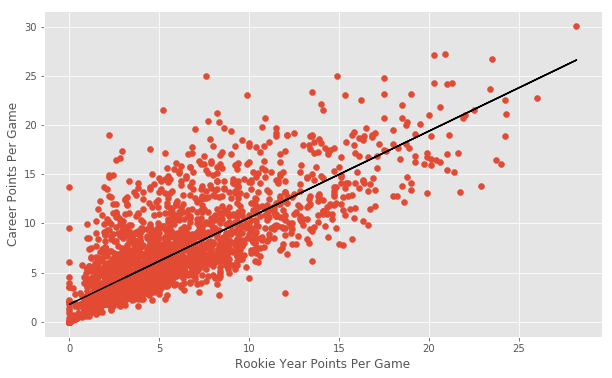

In [25]:
points_ols = sm.ols(formula = "PtsPerGame_c ~ PtsPerGame_r", data = players).fit()
#r for rookie c for career
plt.scatter(x = players["PtsPerGame_r"], y = players["PtsPerGame_c"])
plt.plot(players["PtsPerGame_r"], points_ols.predict(), color = 'k')
plt.xlabel('Rookie Year Points Per Game')
plt.ylabel('Career Points Per Game')
print(points_ols.rsquared)
print(points_ols.pvalues)

0.366053981347
Intercept          8.236589e-01
Games_Played_r    9.787797e-261
dtype: float64


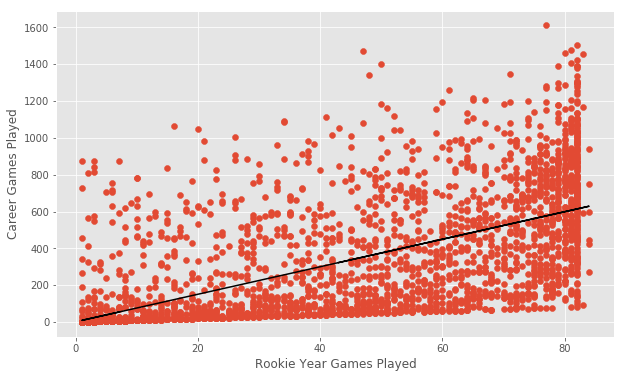

In [27]:
players = players.rename(columns = {"Games Played_c" : "Games_Played_c"})
players = players.rename(columns = {"Games Played_r" : "Games_Played_r"})

games_ols = sm.ols(formula = "Games_Played_c ~ Games_Played_r", data = players).fit()
plt.scatter(x = players["Games_Played_r"], y = players["Games_Played_c"])
plt.plot(players["Games_Played_r"], games_ols.predict(), color = 'k')
plt.xlabel('Rookie Year Games Played')
plt.ylabel('Career Games Played')
print(games_ols.rsquared)
print(games_ols.pvalues)

after doing some initial correlations we can see that between rookie year and career, both points and games plyaed are correlated. It stands to reason that most of the other general stats will also be correlated with each other. Its interesting to note the difference between the two correlations (.67 rsquared vs .32 rsquared). 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          all_NBA_Teams   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     270.4
Date:                Fri, 20 Apr 2018   Prob (F-statistic):           6.81e-58
Time:                        10:17:25   Log-Likelihood:                -3940.1
No. Observations:                2613   AIC:                             7884.
Df Residuals:                    2611   BIC:                             7896.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0590      0.023      2.562      0.010       0.014       0.104
all_Rookie_Team     1.0218      0.062     16.444      0.000       0.900       1.144
==============================================================================
Omnibus:                     3456.756   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           569169.137
Skew:                           7.471   Prob(JB):                         0.00
Kurtosis:                      73.742   Cond. No.                         2.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

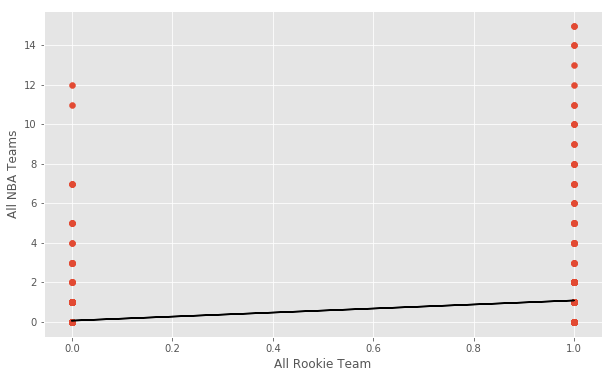

In [28]:
#lets look at rookie awards vs career awards
players = players.rename(columns = {"All-NBA Teams" : "all_NBA_Teams", "All-Rookie Team" : "all_Rookie_Team"})
awards_ols = sm.ols(formula = "all_NBA_Teams ~ all_Rookie_Team", data = players).fit()
plt.scatter(x = players["all_Rookie_Team"], y = players["all_NBA_Teams"])
plt.plot(players["all_Rookie_Team"], awards_ols.predict(), color = 'k')
plt.xlabel('All Rookie Team')
plt.ylabel('All NBA Teams')
awards_ols.summary()

The coefficient here is statistically significant but is surprisingly small. Players only make 1 more All NBA teams on average if they were on the All Rookie team

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          all_NBA_Teams   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     452.6
Date:                Fri, 20 Apr 2018   Prob (F-statistic):           9.46e-93
Time:                        10:17:55   Log-Likelihood:                -3860.0
No. Observations:                2613   AIC:                             7724.
Df Residuals:                    2611   BIC:                             7736.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1410      0.021      6.736      0.000       0.100       0.182
ROY            3.3924      0.159     21.274      0.000       3.080       3.705
==============================================================================
Omnibus:                     3448.189   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           607041.718
Skew:                           7.400   Prob(JB):                         0.00
Kurtosis:                      76.189   Cond. No.                         7.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

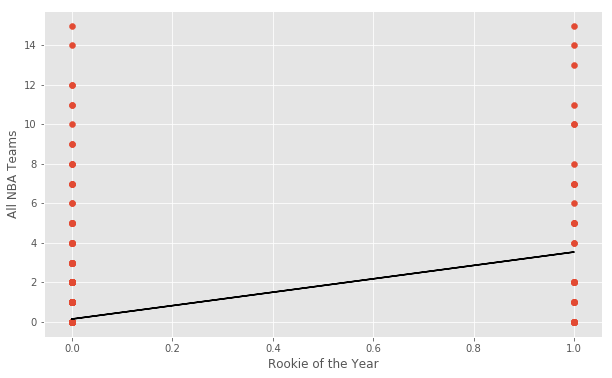

In [30]:
ROY_ols = sm.ols(formula = "all_NBA_Teams ~ ROY", data = players).fit()
plt.scatter(x = players["ROY"], y = players["all_NBA_Teams"])
plt.plot(players["ROY"], ROY_ols.predict(), color = 'k')
plt.xlabel('Rookie of the Year')
plt.ylabel('All NBA Teams')
ROY_ols.summary()

Interestingly enough, the coefficient more than triples when we use simply whether or not a player was rookie of the year. However, since the Rsquared value is only .2 we conclude that this model can't account for very much of the variation in the data.

In [35]:
#going to include columns of interest for a correlation heatmap
columns = ['Age', 'Games_Played_r', 'ORtg_r', 'DRtg_r' , 'TotalRebPerGame_r', 'AstPerGame_r', 'PtsPerGame_r','ROY', 'Games_Played_c', 'ORtg_c', 'DRtg_c' , 'TotalRebPerGame_c', 'AstPerGame_c', 'PtsPerGame_c', 'all_NBA_Teams']
corr_matrix_data = players[columns]


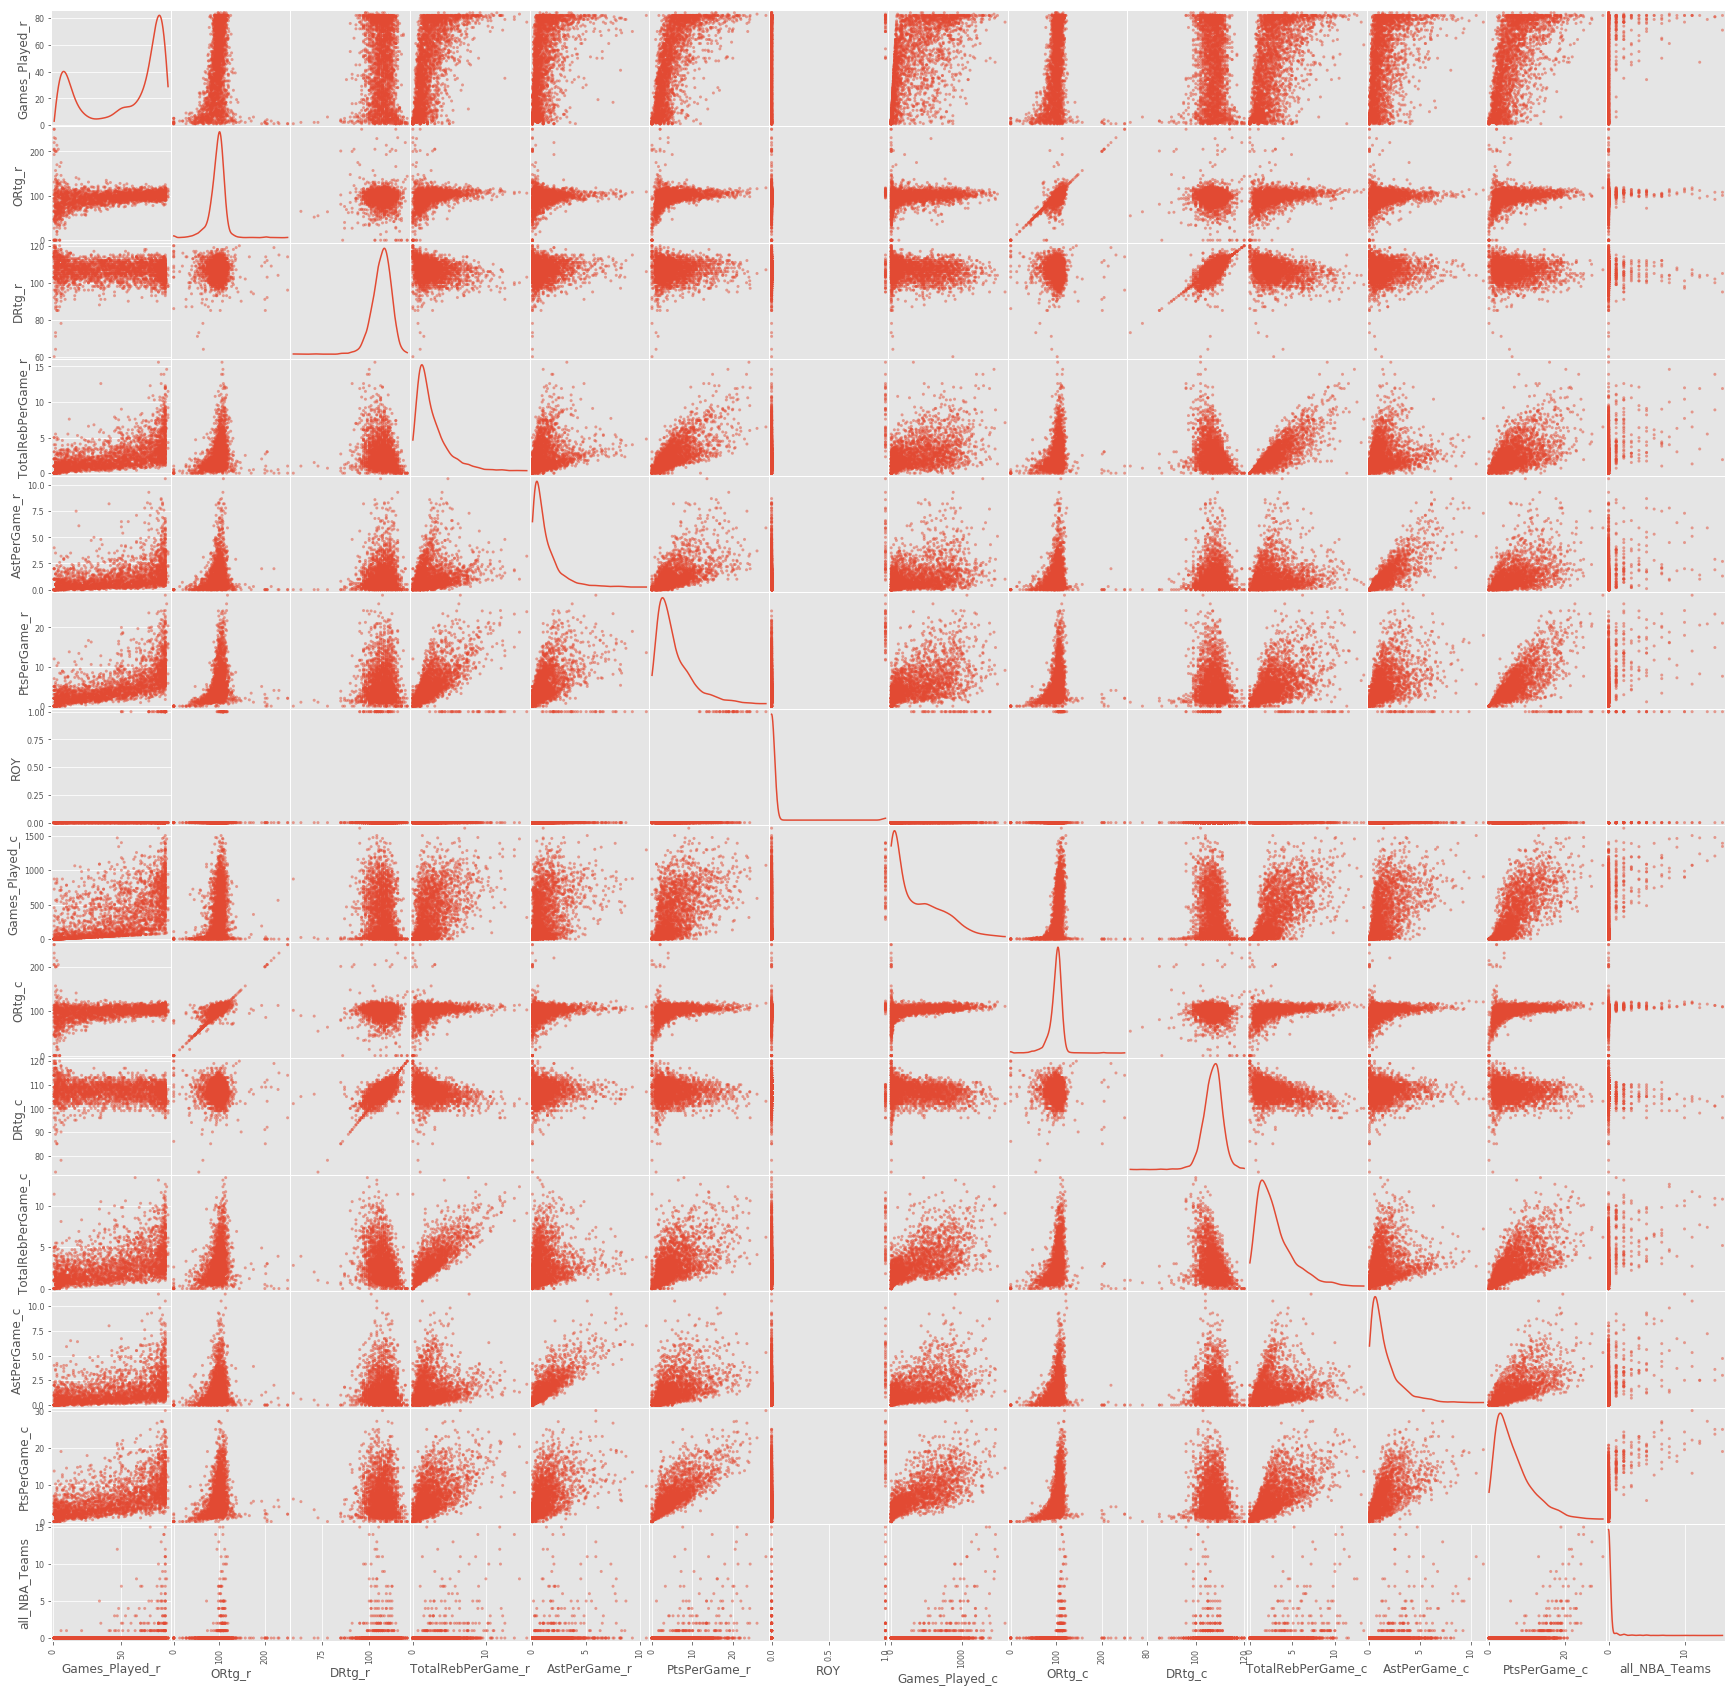

In [36]:
pd.plotting.scatter_matrix(corr_matrix_data, figsize=(30, 30), diagonal = 'kde');

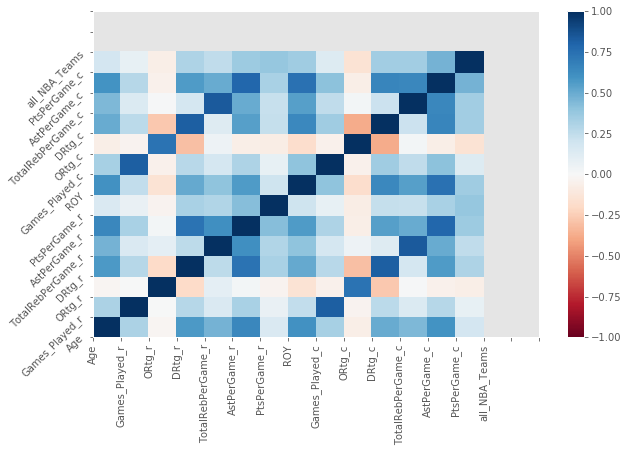

In [37]:
heat_plot = plt.pcolor(corr_matrix_data.corr(), vmin = -1, vmax = 1, cmap='RdBu')
plt.colorbar()
rev_array = reversed(columns)
plt.xticks(np.arange(17), columns , rotation=90)
plt.yticks(np.arange(17),columns, rotation = 45);

There are a few interesting things the scatter matrix and correlation heatmap tell us that we may want to consider later on in our project. First of all, The best age to be a rookie in order to maximize career statistics is 20-22. We also see that most rookie year statistics that we looked at have a fairly high correlation between rookie year and career aside from Games Played and Games Started. We also notice that the Rookie of the Year award has low correlations with every other statistic. This is very interesting to us and confirms the general understanding that not every phenomenal rookie necessarily goes on to become a phenomenal player.

# Project Classification #

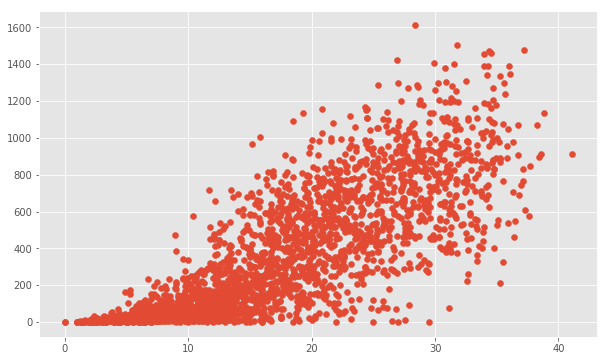

In [79]:
career = career.rename(columns = {"Games Played" : "Games_Played"})
plt.scatter(x = career["MinPerGame"], y = career["Games_Played"])

For the players who don't have information on games started, we will assume that they were starters if they played more than 22 minutes per game.

In [42]:
career['starter'] = np.where(career['MinPerGame']>=22, 1, 0)

In [43]:
career['All_Star'] = np.where(career['All-Star Games'] >= 1, 1, 0)

In [44]:
career['MVP'] = np.where(career['MVPs'] >= 1, 1, 0)

In [45]:
career['Role_Player'] = np.where(np.logical_and(career['MinPerGame']<22, career['Games_Played']>=183), 1, 0)

In [46]:
career['Bust'] = np.where(np.logical_and(career['Games_Played'] < 183, career['MinPerGame']<22), 1, 0)

In [47]:
for index, row in career.iterrows():
    if row['Role_Player'] == 1:
        career.set_value(index,'target','Role_Player')
        if row['All_Star'] == 1:
            career.set_value(index,'target','All_Star')
            if row['MVP'] == 1:
                career.set_value(index,'target','MVP')
    if row['Bust'] == 1:
        career.set_value(index,'target','Bust')
        if row['All_Star'] == 1:
            career.set_value(index,'target','All_Star')
            if row['MVP'] == 1:
                career.set_value(index,'target','MVP')
    if row['starter'] == 1:
        career.set_value(index,'target','Starter')
        if row['All_Star'] == 1:
            career.set_value(index,'target','All_Star')
            if row['MVP'] == 1:
                career.set_value(index,'target','MVP')



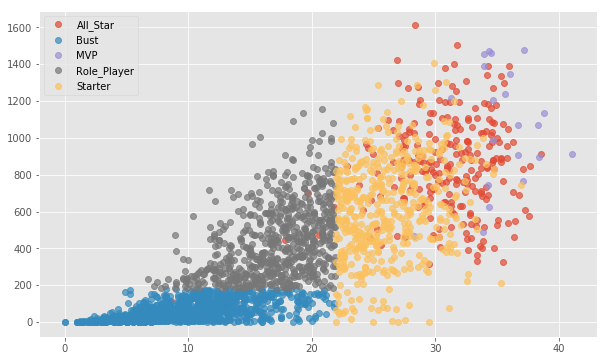

In [48]:
groups = career.groupby('target')
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.MinPerGame, group.Games_Played, marker='o',linestyle='', ms=6,alpha=.7, label=name)
ax.legend()

plt.show()

In [49]:
career['target'].replace('MVP', 1,inplace=True)
career['target'].replace('All_Star', 2,inplace=True)
career['target'].replace('Starter', 3,inplace=True)
career['target'].replace('Role_Player', 4,inplace=True)
career['target'].replace('Bust', 5,inplace=True)


In [50]:
target = career[['target']]

In [51]:
target[pd.isnull(target).any(axis=1)]

,target


In [52]:
rookie[['Draft_Pick']] = rookie[['Draft_Pick']].fillna(value=70)

In [53]:
rookie = rookie.fillna(0)

In [56]:
rookie = rookie.drop(['Name','link','Year','Position'],axis=1)

In [59]:
X = scale(rookie.values)
Y = target.values

In [60]:
XTrain, XTest, yTrain, yTest = train_test_split(X, Y, random_state=1,  test_size=0.8)

In [61]:
model = svm.SVC(kernel='rbf',C=1)
model.fit(XTrain, yTrain.ravel())
expected = yTest
predicted = model.predict(XTest)
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = expected, y_pred = predicted))

print('Accuracy = ', metrics.accuracy_score(y_true = expected, y_pred = predicted))

Confusion Matrix:
[[  0   9   3   1   4]
 [  0  49  91  34  15]
 [  0  23 199  86  74]
 [  0   0  97 202 223]
 [  0   0  36  91 854]]
Accuracy =  0.62362505978


In [62]:
np.where(predicted == 1)[0]

array([], dtype=int64)

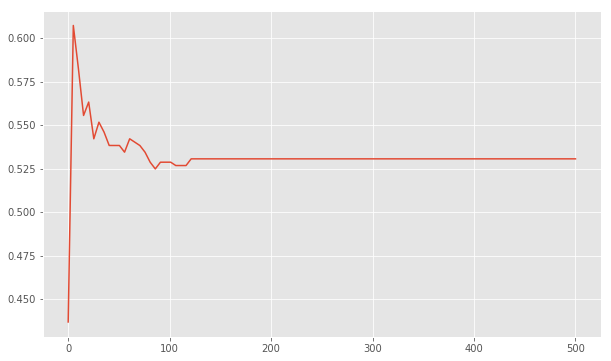

In [63]:
model.get_params()

Cs = np.linspace(.01,500,100)
Accuracies = np.zeros(Cs.shape[0])
for i,C in enumerate(Cs): 
    model = svm.SVC(kernel='rbf', C = C)
    scores = cross_val_score(estimator = model, X = XTrain, y = yTrain.ravel(), cv=4, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
plt.plot(Cs,Accuracies)
plt.show()

In [64]:
clf = KNeighborsClassifier(n_neighbors=48)
clf.fit(XTrain, yTrain.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=48, p=2,
           weights='uniform')

In [65]:
print('Confusion Matrix:')
Expected = yTest
Prediction = clf.predict(XTest)
print(metrics.confusion_matrix(y_true = Expected, y_pred = Prediction))

print('Accuracy = ', metrics.accuracy_score(y_true = Expected, y_pred = Prediction))

Confusion Matrix:
[[  0   5  11   1   0]
 [  0  17 114  34  24]
 [  0   2 192 100  88]
 [  0   0  67 187 268]
 [  0   0  21  91 869]]
Accuracy =  0.604973696796


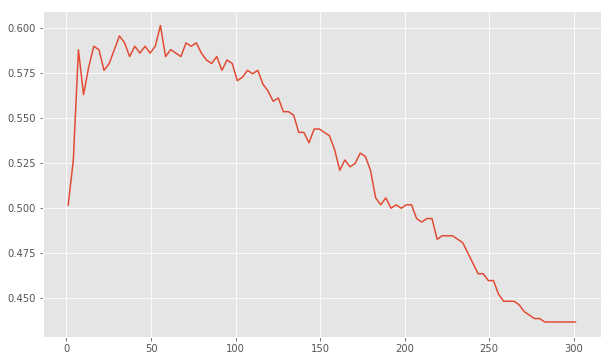

In [66]:
clf.get_params()

Ks = np.linspace(1,301,100)
Accuracies = np.zeros(Ks.shape[0])
for i,K in enumerate(Ks): 
    clf = KNeighborsClassifier(n_neighbors=int(K))
    scores = cross_val_score(estimator = clf, X = XTrain, y = yTrain.ravel(), cv=4, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
plt.plot(Ks,Accuracies)
plt.show()

In [67]:
decisionTree = tree.DecisionTreeClassifier(max_depth=3)
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Accuracy on training data=  0.64367816092
Accuracy on test data=  0.597800095648
Confusion Matrix:
[[  0  10   5   1   1]
 [  0  52  61  57  19]
 [  0  41 137 108  96]
 [  0   3  59 210 250]
 [  0   0  41  89 851]]
Accuracy =  0.597800095648


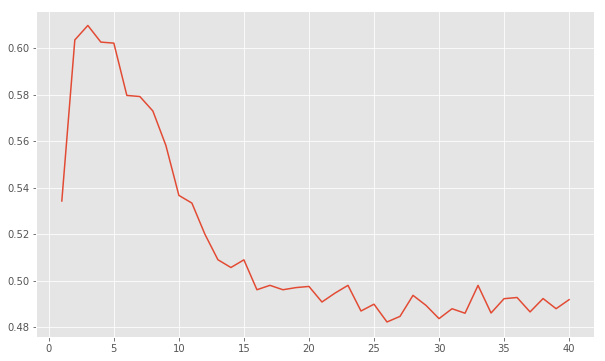

In [68]:
decisionTree.get_params()

Ks = np.linspace(1,40,40)
Accuracies = np.zeros(Ks.shape[0])
for i,K in enumerate(Ks): 
    decisionTree = tree.DecisionTreeClassifier(max_depth=int(K))
    scores = cross_val_score(estimator = decisionTree, X = XTest, y = yTest, cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
plt.plot(Ks,Accuracies)
plt.show()

__Now, I am going to try the same classification but with less predictor variables. I will first start by removing the per 100 variables, after which I'll put those back in and remove the pergame variables__

In [69]:
cols = [c for c in rookie.columns if c[-10:] != 'Per100Poss']
rookie_no100 = rookie[cols]

In [70]:
X = scale(rookie_no100.values)
Y = target.values

XTrain, XTest, yTrain, yTest = train_test_split(X, Y, random_state=1,  test_size=0.8)

model = svm.SVC(kernel='rbf',C=2)
model.fit(XTrain, yTrain.ravel())
expected = yTest
predicted = model.predict(XTest)
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = expected, y_pred = predicted))

print('Accuracy = ', metrics.accuracy_score(y_true = expected, y_pred = predicted))

Confusion Matrix:
[[  0   8   3   1   5]
 [  0  52  86  38  13]
 [  0  29 188  99  66]
 [  0   3  94 207 218]
 [  0   0  34  88 859]]
Accuracy =  0.624581539933


In [71]:
clf = KNeighborsClassifier(n_neighbors=48)
clf.fit(XTrain, yTrain.ravel())

print('Confusion Matrix:')
Expected = yTest
Prediction = clf.predict(XTest)
print(metrics.confusion_matrix(y_true = Expected, y_pred = Prediction))

print('Accuracy = ', metrics.accuracy_score(y_true = Expected, y_pred = Prediction))

Confusion Matrix:
[[  0   7   9   0   1]
 [  0  16 117  38  18]
 [  0   5 191 105  81]
 [  0   0  67 196 259]
 [  0   0  20  91 870]]
Accuracy =  0.608799617408


In [72]:
decisionTree = tree.DecisionTreeClassifier(max_depth=3)
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Accuracy on training data=  0.64367816092
Accuracy on test data=  0.597800095648
Confusion Matrix:
[[  0  10   5   1   1]
 [  0  52  61  57  19]
 [  0  41 137 108  96]
 [  0   3  59 210 250]
 [  0   0  41  89 851]]
Accuracy =  0.597800095648


__Now keeping per100 and getting rid of per game__

In [73]:
cols = [c for c in rookie.columns if c[-7:] != 'PerGame']
rookie_noPerGame = rookie[cols]

In [74]:
X = scale(rookie_noPerGame.values)
Y = target.values

XTrain, XTest, yTrain, yTest = train_test_split(X, Y, random_state=1,  test_size=0.8)

model = svm.SVC(kernel='rbf',C=1)
model.fit(XTrain, yTrain.ravel())
expected = yTest
predicted = model.predict(XTest)
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = expected, y_pred = predicted))

print('Accuracy = ', metrics.accuracy_score(y_true = expected, y_pred = predicted))

Confusion Matrix:
[[  0   8   4   2   3]
 [  0  49  84  44  12]
 [  0  25 164 115  78]
 [  0   2  65 234 221]
 [  0   0  17 109 855]]
Accuracy =  0.622668579627


In [75]:
clf = KNeighborsClassifier(n_neighbors=48)
clf.fit(XTrain, yTrain.ravel())

print('Confusion Matrix:')
Expected = yTest
Prediction = clf.predict(XTest)
print(metrics.confusion_matrix(y_true = Expected, y_pred = Prediction))

print('Accuracy = ', metrics.accuracy_score(y_true = Expected, y_pred = Prediction))

Confusion Matrix:
[[  0   9   7   1   0]
 [  0  23 101  45  20]
 [  0   7 167 118  90]
 [  0   0  59 213 250]
 [  0   0  17 113 851]]
Accuracy =  0.599713055954


In [76]:
decisionTree = tree.DecisionTreeClassifier(max_depth=3)
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Accuracy on training data=  0.64367816092
Accuracy on test data=  0.57962697274
Confusion Matrix:
[[  0   8   8   0   1]
 [  0  52 112   6  19]
 [  0  34 235  12 101]
 [  0   7 205  55 255]
 [  0   0  97  14 870]]
Accuracy =  0.57962697274


# Clustering #

In [80]:
for col in career:
    if(col != "Name" and col != "link"):
        try:
            career[col] = scale(career[col])
        except:
            pass
    
career_data = career.drop(["Name", "link", "League", "Year"], axis = 1)

/Users/travistiner/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [81]:
career = career.dropna()

In [83]:
career_data = career.drop(["Name", "link", "League", "Year"], axis = 1)

y_pred = KMeans(n_clusters=4, n_init=10, init='random', max_iter=1).fit_predict(career_data)
agg_cluster_model = AgglomerativeClustering(linkage='average', affinity='euclidean', n_clusters=4)
y_pred = agg_cluster_model.fit_predict(career_data)


[[  9.80000000e+01   1.75300000e+03   3.44272706e+00   2.00000000e+00]
 [  5.09000000e+02   1.40500000e+03   3.57155071e+00   2.00000000e+00]
 [  1.20200000e+03   2.03600000e+03   3.57167832e+00   2.00000000e+00]
 [  2.60000000e+02   2.02400000e+03   3.61913510e+00   2.00000000e+00]
 [  3.30000000e+01   3.18000000e+02   3.62722409e+00   2.00000000e+00]]


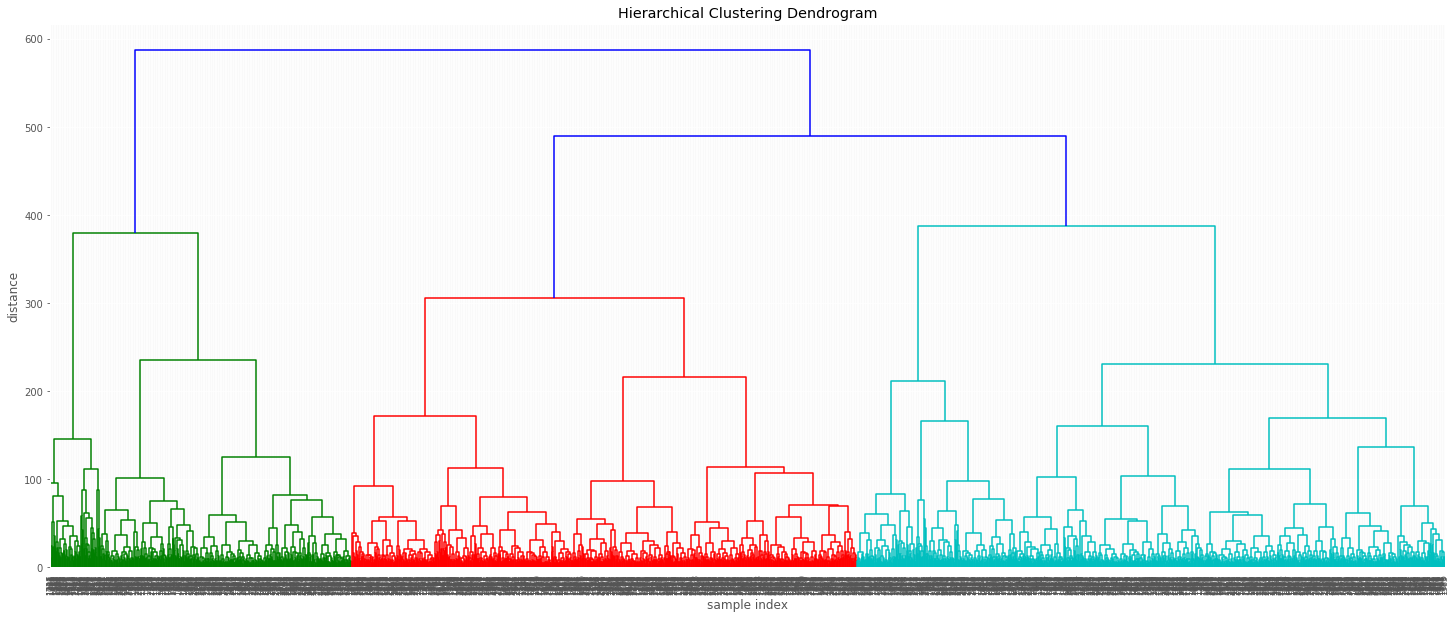

In [84]:
Z = linkage(career_data, 'ward') # generate the linkage array
print(Z[:5])
# dendrogram plot
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()
